Copyright 2020 Matthias Anderer

Copyright for aggregation code snippets 2020 by user: https://www.kaggle.com/lebroschar (name unknown)

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.

# Overall approach

We have two different inputs: 

1) Bottom level forecasts on item level (30490 signal) that are derived from a lgbm model that models a probability of this item being bought based on datatime features, price features and a few other features that are not time dependent. (Credits: https://www.kaggle.com/kyakovlev/m5-simple-fe)
2) Top level forecasts for the levels 1-5 that are created with N-Beats. 

We can now aggregate the bottom level "probabilit draws" up to the levels 1-5. By comparing/aligning the possible results we can select the most suitable probability distribution for the forecast period. ( The multiplier in the custom loss of the bottom level lgbm models seems to help adjust for trend or other effects not fully understood yet)

### Overall analysis result: 

The multiplier 0.95 seems to represent the lowest available fit so we build an ensemble with the 2 upper and 2 lower distributions to generate a robust test loss.
<br><br>
Final-11: 0.9 <br>
Final-12: 0.93 <br>
Final-17: 0.95 <br>
Final-13: 0.97 <br>
Final-16: 0.99

In [56]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import warnings
warnings.simplefilter(action='ignore')

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns



## Load NBEATS reference predictions for global alignment

In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


NBeats predictions trained and predicted on Colab with two different settings (only change in setting is num_epochs to get slightly different ensembles)

In [58]:
nbeats_pred01_df = pd.read_csv('/content/drive/MyDrive/m5-accuracy-competition/results/nbeats_toplvl_forecasts2_epoch10_num_batches_1000.csv')
nbeats_pred02_df = pd.read_csv('/content/drive/MyDrive/m5-accuracy-competition/results/nbeats_toplvl_forecasts2_epoch10_num_batches_1000.csv')

#nbeats_pred_df.head()

## Load bottom level lgb predictions for alignment

In [59]:
BUILD_ENSEMBLE = True

In [60]:
if BUILD_ENSEMBLE:
    
    pred_01_df = pd.read_csv('/content/drive/MyDrive/m5-accuracy-competition/results/submission_0.90.csv')
    pred_02_df = pd.read_csv('/content/drive/MyDrive/m5-accuracy-competition/results/submission_0.93.csv')
    pred_03_df = pd.read_csv('/content/drive/MyDrive/m5-accuracy-competition/results/submission_0.95.csv')
    pred_04_df = pd.read_csv('/content/drive/MyDrive/m5-accuracy-competition/results/submission_0.97.csv')
    pred_05_df = pd.read_csv('/content/drive/MyDrive/m5-accuracy-competition/results/submission_0.99.csv')
    #pred_06_df = pd.read_csv('..')

    avg_pred = ( np.array(pred_01_df.values[:,1:]) 
                + np.array(pred_02_df.values[:,1:]) 
                + np.array(pred_03_df.values[:,1:])
                + np.array(pred_04_df.values[:,1:])  
                + np.array(pred_05_df.values[:,1:])  
               # + np.array(pred_06_df.values[:,1:])  
               ) /5.0
    
    ## Loading predictions
    valid_pred_df = pd.DataFrame(avg_pred, columns=pred_01_df.columns[1:])
    submission_pred_df = pd.concat([pred_01_df['id'],valid_pred_df],axis=1)
    
else:
    print('Should not submit single distibution')
    #submission_pred_df = pd.read_csv('../input/m5-final-13/submission_v1.csv')

## Fill validation rows - we have no info about validation scoring


Even though it would not make sense at all to score public validation data it might be safest to set the submission validation values to the ground truth....

Spamming the LB a bit more ... 

In [61]:
validation_gt_data = pd.read_csv('/content/drive/MyDrive/m5-accuracy-competition/input/sales_train_evaluation.csv')
validation_gt_data['id'] = validation_gt_data['id'].str.replace('_evaluation','_validation')
validation_gt_data = validation_gt_data.drop(['item_id','dept_id','cat_id','store_id','state_id'],axis=1)
validation_gt_data = pd.concat([validation_gt_data[['id']],validation_gt_data.iloc[:,-28:]],axis=1)
validation_gt_data.columns=submission_pred_df.columns.values
#validation_gt_data

In [62]:
submission_pred_df = pd.concat([validation_gt_data, submission_pred_df.iloc[30490:,:]],axis=0).reset_index(drop=True)
submission_pred_df

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,2,0,3,5,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_validation,0,1,0,0,0,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,1,1,0,2,1,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_validation,0,0,1,2,4,1,6,4,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_validation,1,0,2,3,1,0,3,2,3,...,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0.811978,0.678273,0.678273,0.678273,0.801154,1.142716,1.153842,0.908812,0.678273,...,0.911571,1.203752,1.198238,0.819799,0.710735,0.710735,0.710735,0.833616,1.179547,1.18656
60976,FOODS_3_824_WI_3_evaluation,0.756993,0.621691,0.621691,0.621691,0.753268,1.100218,1.111344,0.864087,0.621691,...,0.871798,1.164732,1.162307,0.765964,0.660719,0.660719,0.660719,0.792296,1.143615,1.153405
60977,FOODS_3_825_WI_3_evaluation,0.986588,0.847466,0.847466,0.847466,1.021646,1.370305,1.381431,1.068754,0.847466,...,1.152864,1.447507,1.441993,1.003512,0.894448,0.894448,0.894448,1.068627,1.421655,1.428668
60978,FOODS_3_826_WI_3_evaluation,1.333581,1.200802,1.200802,1.200802,1.421966,1.841961,1.842227,1.41796,1.200802,...,1.534255,1.904868,1.888494,1.349728,1.240663,1.240663,1.240663,1.461828,1.886191,1.876571


## Only work on evaluation forecasts

In [63]:
bottom_lvl_pred_df = submission_pred_df.iloc[30490:,:].reset_index(drop=True)
bottom_lvl_pred_df

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_evaluation,0.784343,0.715829,0.716786,0.719934,0.792192,0.897693,0.877694,0.853244,0.73763,...,0.869669,0.948606,0.922672,0.77861,0.72078,0.719178,0.725372,0.840306,0.954716,0.859164
1,HOBBIES_1_002_CA_1_evaluation,0.2788,0.209735,0.210692,0.213068,0.299648,0.404398,0.387196,0.327314,0.273546,...,0.330748,0.412124,0.39287,0.278486,0.220105,0.217991,0.225819,0.312847,0.417255,0.293442
2,HOBBIES_1_003_CA_1_evaluation,0.361227,0.291751,0.292708,0.295084,0.38222,0.484823,0.467622,0.419806,0.355562,...,0.415797,0.495026,0.475773,0.36175,0.302951,0.300838,0.308666,0.39625,0.498511,0.361841
3,HOBBIES_1_004_CA_1_evaluation,1.559866,1.439565,1.445765,1.497414,1.971291,2.924074,3.169073,1.867278,1.505073,...,1.950736,2.955636,3.164977,1.551238,1.438793,1.431204,1.486254,1.960579,2.968836,2.629357
4,HOBBIES_1_005_CA_1_evaluation,0.992363,0.916,0.906438,0.908814,1.028305,1.322796,1.331416,1.031096,0.974589,...,0.994095,1.303612,1.35217,0.997863,0.93579,0.933676,0.93987,1.059082,1.356159,1.180025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,0.811978,0.678273,0.678273,0.678273,0.801154,1.142716,1.153842,0.908812,0.678273,...,0.911571,1.203752,1.198238,0.819799,0.710735,0.710735,0.710735,0.833616,1.179547,1.18656
30486,FOODS_3_824_WI_3_evaluation,0.756993,0.621691,0.621691,0.621691,0.753268,1.100218,1.111344,0.864087,0.621691,...,0.871798,1.164732,1.162307,0.765964,0.660719,0.660719,0.660719,0.792296,1.143615,1.153405
30487,FOODS_3_825_WI_3_evaluation,0.986588,0.847466,0.847466,0.847466,1.021646,1.370305,1.381431,1.068754,0.847466,...,1.152864,1.447507,1.441993,1.003512,0.894448,0.894448,0.894448,1.068627,1.421655,1.428668
30488,FOODS_3_826_WI_3_evaluation,1.333581,1.200802,1.200802,1.200802,1.421966,1.841961,1.842227,1.41796,1.200802,...,1.534255,1.904868,1.888494,1.349728,1.240663,1.240663,1.240663,1.461828,1.886191,1.876571


## Reconstruct level descriptions for aggregation

In [64]:
name_cols = bottom_lvl_pred_df.id.str.split(pat='_',expand=True)
name_cols['dept_id']=name_cols[0]+'_'+name_cols[1]
name_cols['store_id']=name_cols[3]+'_'+name_cols[4]
name_cols = name_cols.rename(columns={0: "cat_id", 3: "state_id"})
name_cols = name_cols.drop([1,2,4,5],axis=1)
bottom_lvl_pred_df = pd.concat([name_cols,bottom_lvl_pred_df],axis=1)

## Build aggregates of predictions

In [65]:
# Get column groups
cat_cols = ['id', 'dept_id', 'cat_id',  'store_id', 'state_id']
ts_cols = [col for col in bottom_lvl_pred_df.columns if col not in cat_cols]
ts_dict = {t: int(t[1:]) for t in ts_cols}

# Describe data
print('  unique forecasts: %i' % bottom_lvl_pred_df.shape[0])
for col in cat_cols:
    print('   N_unique %s: %i' % (col, bottom_lvl_pred_df[col].nunique()))


  unique forecasts: 30490
   N_unique id: 30490
   N_unique dept_id: 7
   N_unique cat_id: 3
   N_unique store_id: 10
   N_unique state_id: 3


In [66]:
# 1. All products, all stores, all states (1 series)
all_sales = pd.DataFrame(bottom_lvl_pred_df[ts_cols].sum()).transpose()
all_sales['id_str'] = 'all'
all_sales = all_sales[ ['id_str'] +  [c for c in all_sales if c not in ['id_str']] ]

In [67]:
# 2. All products by state (3 series)
state_sales = bottom_lvl_pred_df.groupby('state_id',as_index=False)[ts_cols].sum()
state_sales['id_str'] = state_sales['state_id'] 
state_sales = state_sales[ ['id_str'] +  [c for c in state_sales if c not in ['id_str']] ]
state_sales = state_sales.drop(['state_id'],axis=1)

In [68]:
# 3. All products by store (10 series)
store_sales = bottom_lvl_pred_df.groupby('store_id',as_index=False)[ts_cols].sum()
store_sales['id_str'] = store_sales['store_id'] 
store_sales = store_sales[ ['id_str'] +  [c for c in store_sales if c not in ['id_str']] ]
store_sales = store_sales.drop(['store_id'],axis=1)

In [69]:
# 4. All products by category (3 series)
cat_sales = bottom_lvl_pred_df.groupby('cat_id',as_index=False)[ts_cols].sum()
cat_sales['id_str'] = cat_sales['cat_id'] 
cat_sales = cat_sales[ ['id_str'] +  [c for c in cat_sales if c not in ['id_str']] ]
cat_sales = cat_sales.drop(['cat_id'],axis=1)


In [70]:
# 5. All products by department (7 series)
dept_sales = bottom_lvl_pred_df.groupby('dept_id',as_index=False)[ts_cols].sum()
dept_sales['id_str'] = dept_sales['dept_id'] 
dept_sales = dept_sales[ ['id_str'] +  [c for c in dept_sales if c not in ['id_str']] ]
dept_sales = dept_sales.drop(['dept_id'],axis=1)

In [71]:
all_pred_agg = pd.concat([all_sales,state_sales,store_sales,cat_sales,dept_sales],ignore_index=True)


In [72]:
all_pred_agg.head()

,id_str,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,all,35956.741577,33231.233384,33172.238507,33141.610294,37212.102724,45699.304197,46355.201503,38453.544589,33689.699522,...,39445.559969,47350.616559,47755.294153,36623.359842,34305.271603,34205.931308,34310.372219,38452.699605,47231.311566,46279.927504
1,CA,14594.614938,13172.045594,13117.941338,13085.417605,15047.323991,18521.875785,18927.342072,16142.385116,13609.594846,...,16180.269594,19432.129001,19765.431954,15017.352033,13757.675382,13678.107995,13774.940681,15768.520095,19450.358655,18436.288685
2,TX,11239.397124,10357.514574,10354.515019,10356.106946,11691.062686,14566.862081,14733.409536,11904.394001,10375.715798,...,12420.955378,15067.429724,15115.443922,11402.228443,10688.070825,10674.987313,10679.309715,12045.160036,14974.975014,15007.296412
3,WI,10122.729515,9701.673217,9699.782149,9700.085742,10473.716047,12610.566332,12694.449895,10406.765472,9704.388878,...,10844.334997,12851.057834,12874.418276,10203.779366,9859.525396,9852.835999,9856.121823,10639.019473,12805.977897,12836.342408
4,CA_1,4354.073254,3803.089769,3765.381959,3750.130764,4440.568509,5468.98979,5696.744542,5096.056737,4128.451983,...,4851.362135,5864.874568,6126.327235,4595.038529,4058.071136,4004.776619,4088.796243,4775.573299,5941.68775,5235.604944


In [73]:
nbeats_pred01_df.head()

,id_str,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,all,40732.769531,37646.410156,36690.117188,36102.503906,41145.328125,50240.378906,50426.632812,40571.210938,38385.621094,...,44817.285156,53967.351562,56115.773438,43175.179688,39266.757812,39118.195312,39711.585938,44273.191406,51545.574219,53709.324219
1,CA,18155.419922,16453.486328,15955.107422,15756.759766,17743.085938,22401.509766,23207.396484,18096.388672,16745.544922,...,18402.572266,22387.144531,23687.681641,17754.613281,16119.811523,15580.849609,15986.893555,18041.560547,22225.835938,23426.039062
2,TX,11597.666016,10726.625977,10267.763672,10283.673828,11351.259766,13070.493164,13589.477539,11248.804688,10490.802734,...,11940.396484,13830.811523,14489.971680,11959.622070,10588.580078,10722.570312,10830.297852,11515.588867,13201.502930,14073.082031
3,WI,11553.846680,10585.724609,10412.964844,10345.573242,12382.079102,14853.382812,13596.064453,11237.810547,11190.692383,...,14375.654297,17651.523438,17161.517578,13190.000977,12441.955078,13358.256836,12374.513672,13780.456055,16482.808594,15182.294922
4,CA_1,4620.690918,4110.320801,3972.738281,3895.819824,4455.482910,5804.535645,5969.791992,4557.252441,4164.983398,...,4803.039551,5932.771484,6250.693848,4544.407227,4079.181641,3970.671387,4073.426025,4747.367188,5941.613770,6232.083496


# Calculating comparision metrics

## Interpretation

If prediction is bigger than "true" values error will be positive -> prediction is overshooting (pos error)

If prediction is smaller than "true" values error will be negative -> prediction is undershooting (neg error) 


## NBeats 01

In [74]:
metrics_df = nbeats_pred01_df[['id_str']]

## Calculate errors
## CAUTION: nbeats_pred_df is "truth"/actual values in this context
error = ( np.array(all_pred_agg.values[:,1:]) - np.array(nbeats_pred01_df.values[:,1:]) ) 

## Calc RMSSE
successive_diff = np.diff(nbeats_pred01_df.values[:,1:]) ** 2
denom = successive_diff.mean(1)

num = error.mean(1)**2
rmsse = num / denom

metrics_df['rmsse'] = rmsse

## Not so clean Pandas action :-) - supressing warnings for now...
metrics_df['mean_error'] = error.mean(1)
metrics_df['mean_abs_error'] = np.absolute(error).mean(1)

squared_error = error **2
mean_squ_err = np.array(squared_error.mean(1), dtype=np.float64) 

metrics_df['rmse'] = np.sqrt( mean_squ_err )

metrics_df

,id_str,rmsse,mean_error,mean_abs_error,rmse
0,all,0.858572,-5031.394016,5031.394016,5217.090655
1,CA,1.057801,-2775.935457,2775.935457,2891.075520
2,TX,0.183432,526.707129,640.880843,803.581702
3,WI,2.333834,-2636.111629,2636.111629,2900.010212
4,CA_1,0.008464,-70.663292,156.769254,261.174970
5,CA_2,0.207627,-472.643886,489.997251,632.135186
6,CA_3,5.652287,-1736.729254,1736.729254,1761.952975
7,CA_4,5.913917,-563.023982,563.023982,591.410907
8,TX_1,0.049297,-99.320327,223.75518,263.438090
9,TX_2,0.44526,301.693624,344.938304,438.436702


## NBeats 02

In [75]:
metrics_df = nbeats_pred02_df[['id_str']]

## Calculate errors
## CAUTION: nbeats_pred_df is "truth"/actual values in this context
error = ( np.array(all_pred_agg.values[:,1:]) - np.array(nbeats_pred02_df.values[:,1:]) ) 

## Calc RMSSE
successive_diff = np.diff(nbeats_pred02_df.values[:,1:]) ** 2
denom = successive_diff.mean(1)

num = error.mean(1)**2
rmsse = num / denom

metrics_df['rmsse'] = rmsse

## Not so clean Pandas action :-) - supressing warnings for now...
metrics_df['mean_error'] = error.mean(1)
metrics_df['mean_abs_error'] = np.absolute(error).mean(1)

squared_error = error **2
mean_squ_err = np.array(squared_error.mean(1), dtype=np.float64) 

metrics_df['rmse'] = np.sqrt( mean_squ_err )

metrics_df

,id_str,rmsse,mean_error,mean_abs_error,rmse
0,all,0.858572,-5031.394016,5031.394016,5217.090655
1,CA,1.057801,-2775.935457,2775.935457,2891.075520
2,TX,0.183432,526.707129,640.880843,803.581702
3,WI,2.333834,-2636.111629,2636.111629,2900.010212
4,CA_1,0.008464,-70.663292,156.769254,261.174970
5,CA_2,0.207627,-472.643886,489.997251,632.135186
6,CA_3,5.652287,-1736.729254,1736.729254,1761.952975
7,CA_4,5.913917,-563.023982,563.023982,591.410907
8,TX_1,0.049297,-99.320327,223.75518,263.438090
9,TX_2,0.44526,301.693624,344.938304,438.436702


# Visualizations

### NBeats 01

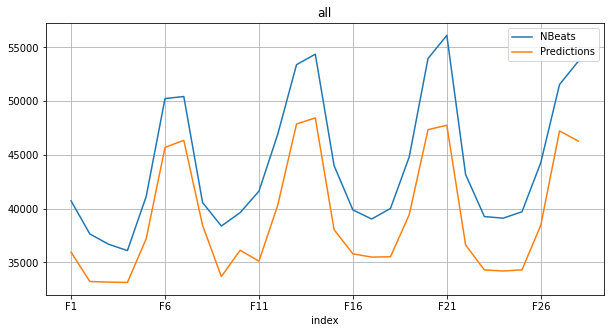

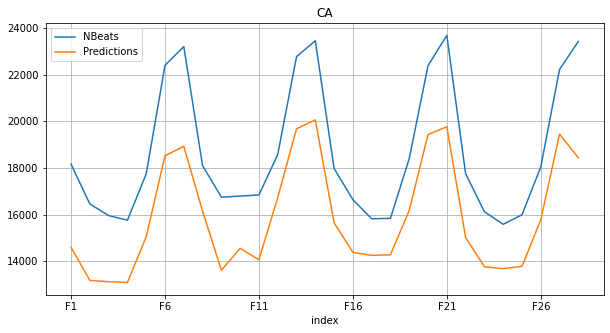

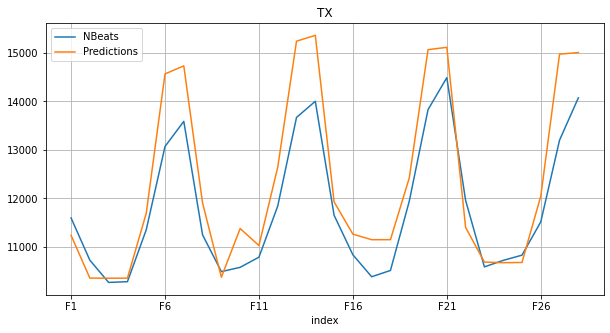

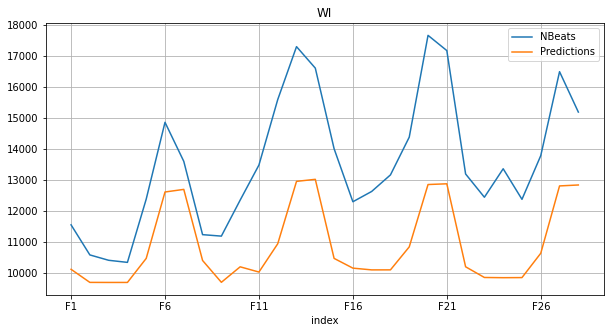

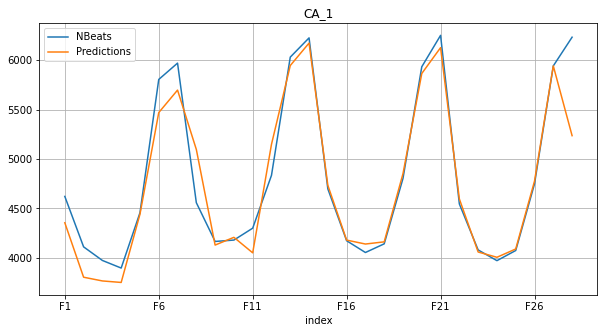

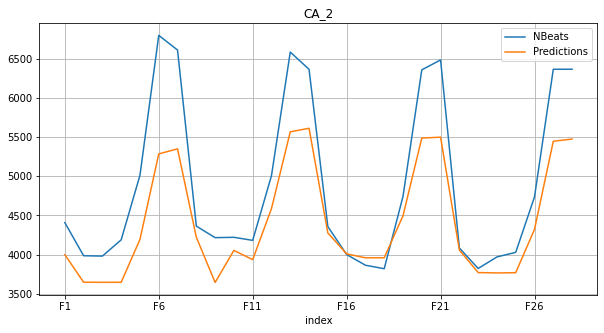

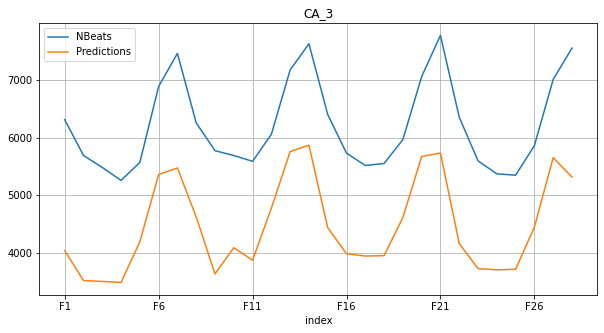

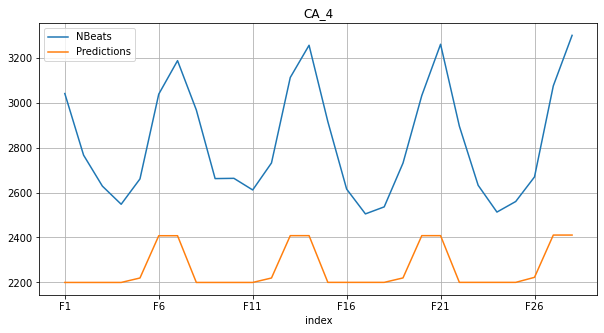

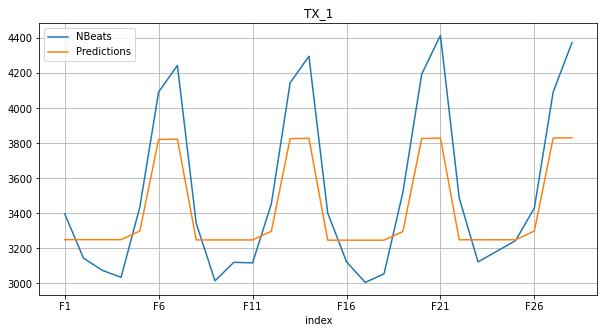

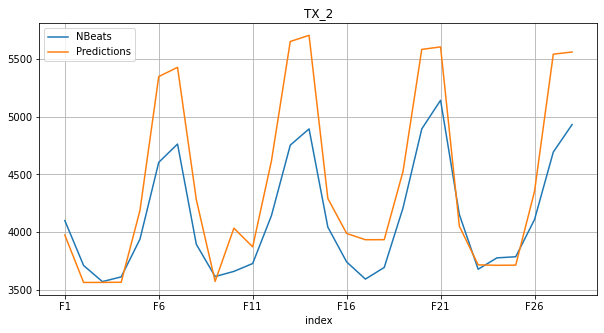

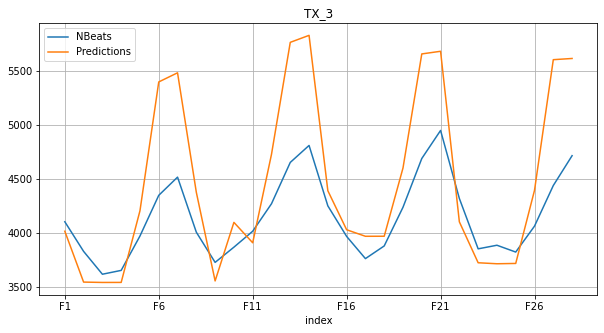

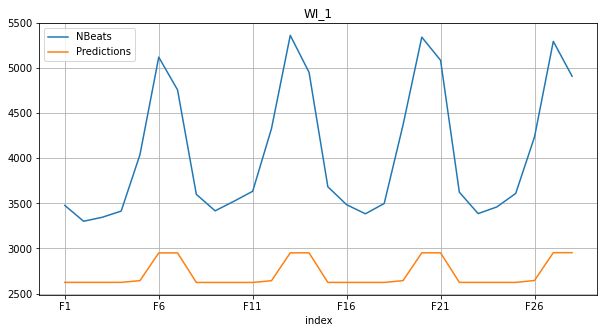

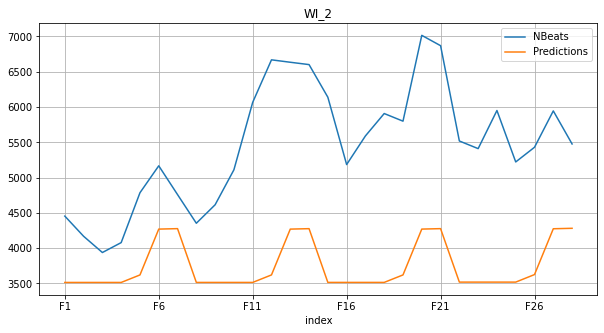

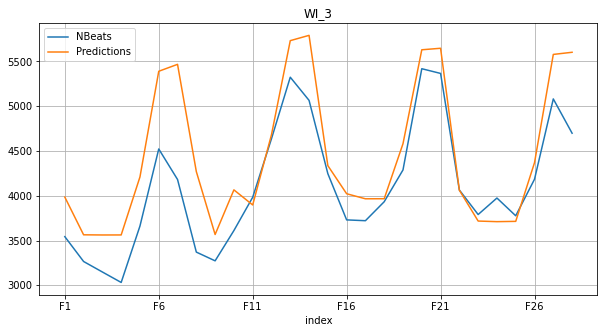

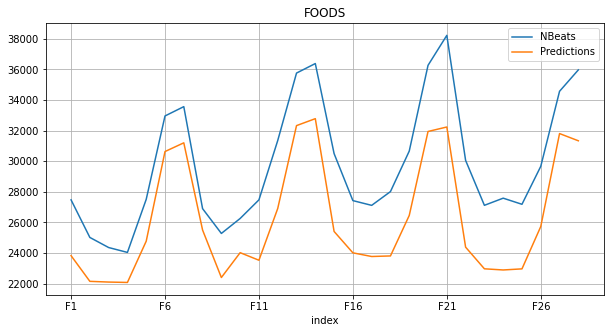

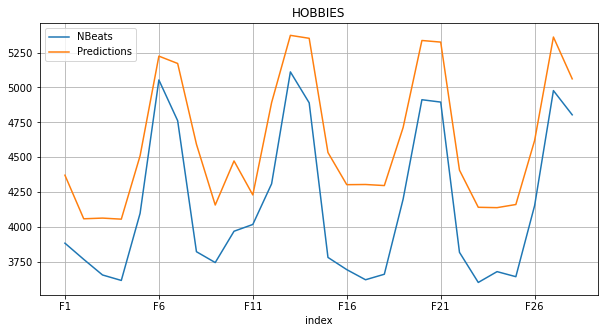

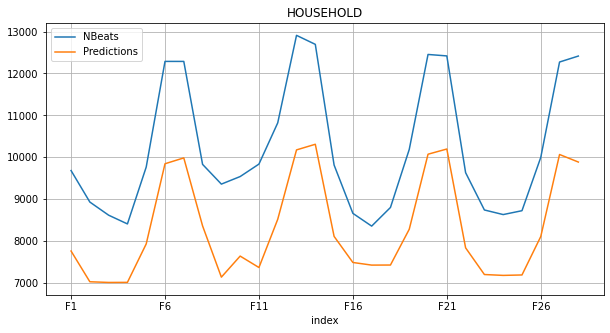

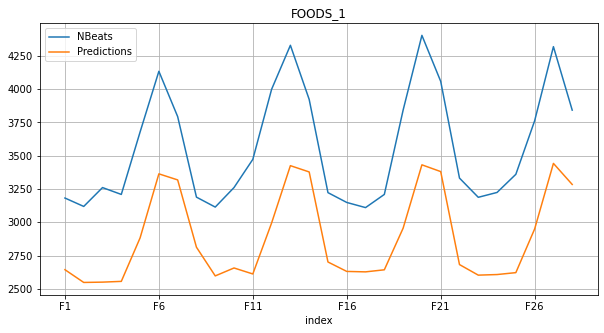

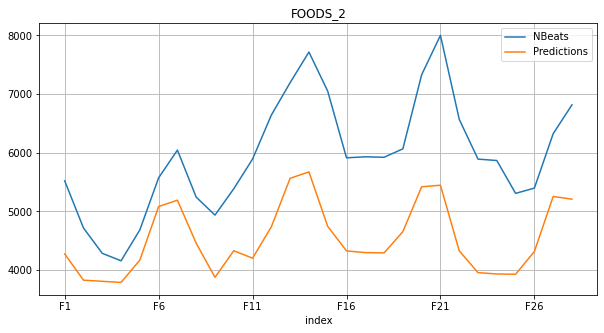

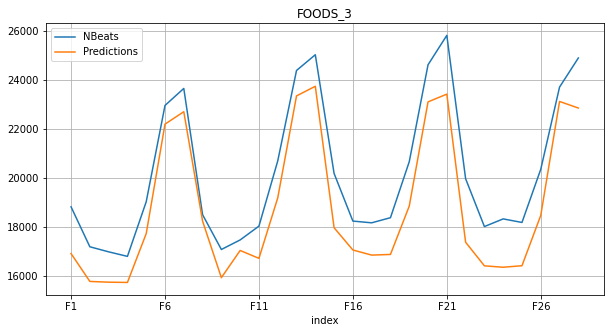

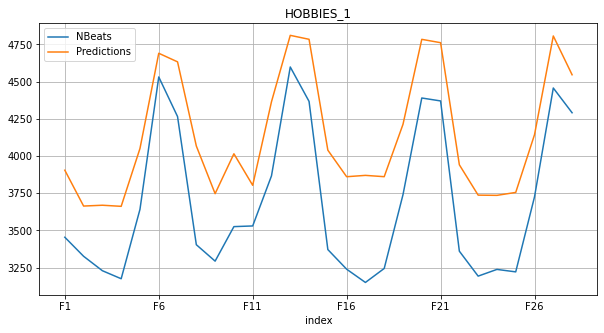

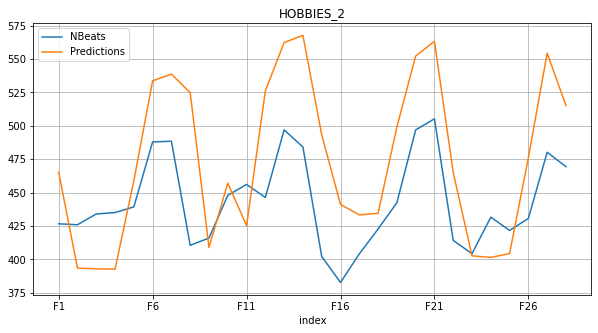

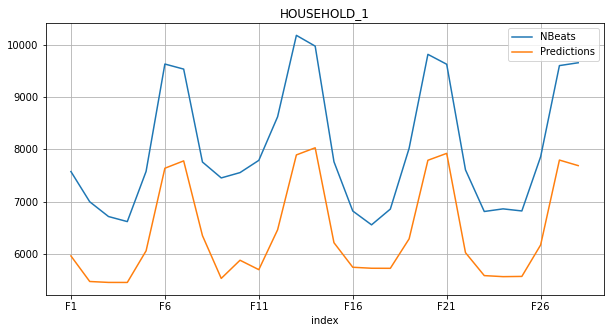

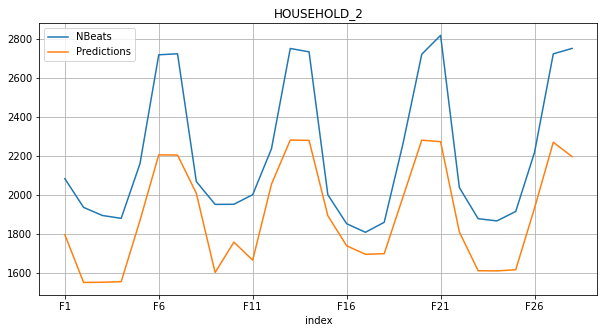

In [76]:
for i in range(0,nbeats_pred01_df.shape[0]):
    plot_df = pd.concat( [nbeats_pred01_df.iloc[i], all_pred_agg.iloc[i] ]  , axis=1, ignore_index=True)
    plot_df = plot_df.iloc[1:,]
    plot_df = plot_df.rename(columns={0:'NBeats',1:'Predictions'})
    plot_df = plot_df.reset_index()
    #plot_df
    
    plot_df.plot(x='index', y=['NBeats', 'Predictions'] ,figsize=(10,5), grid=True, title=nbeats_pred02_df.iloc[i,0]  )

## NBeats 02

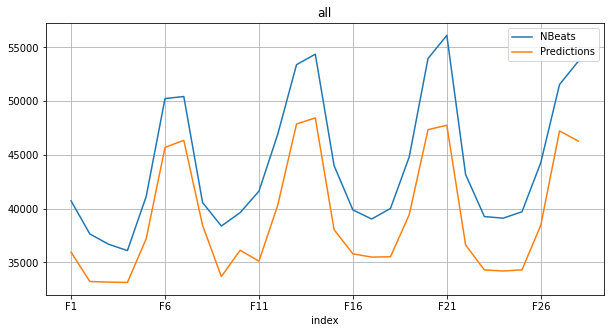

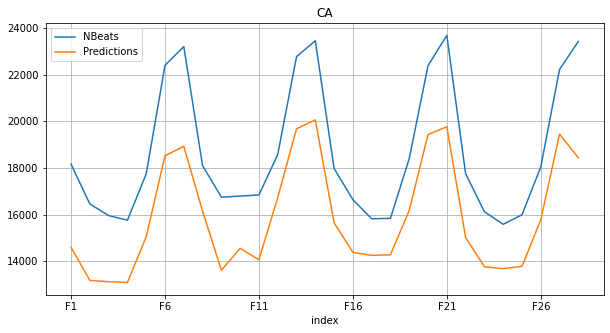

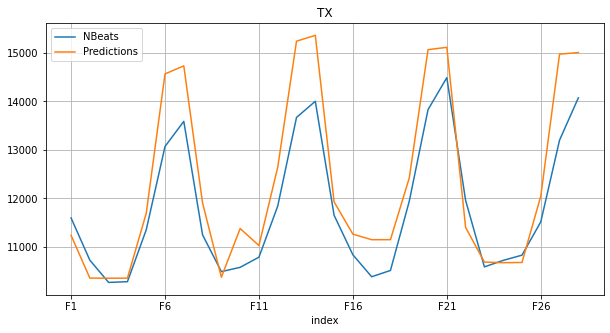

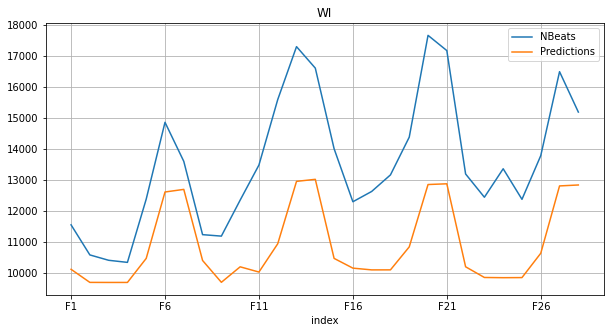

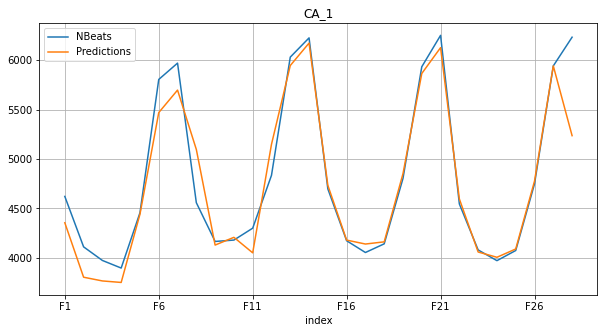

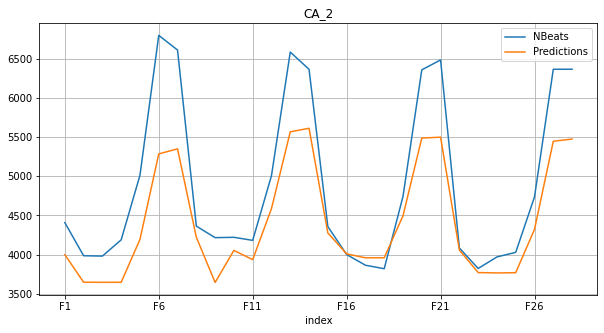

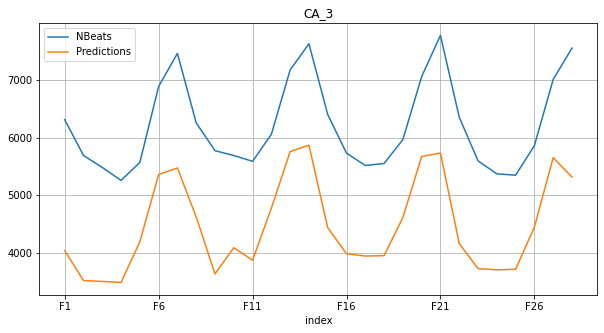

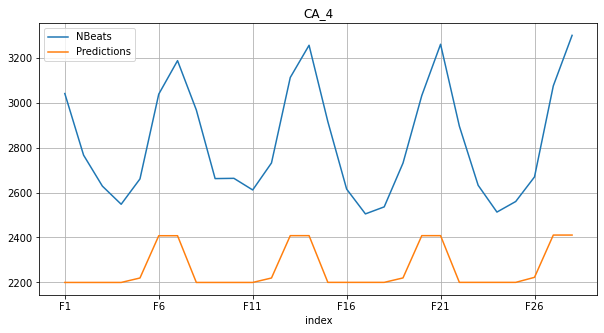

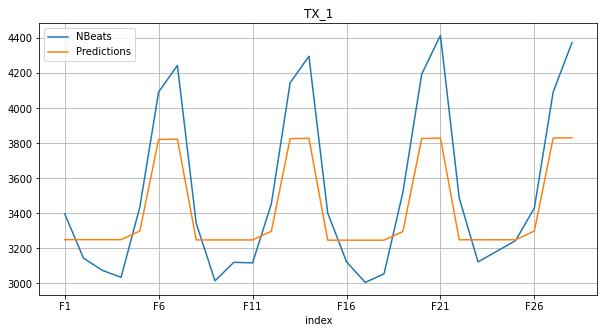

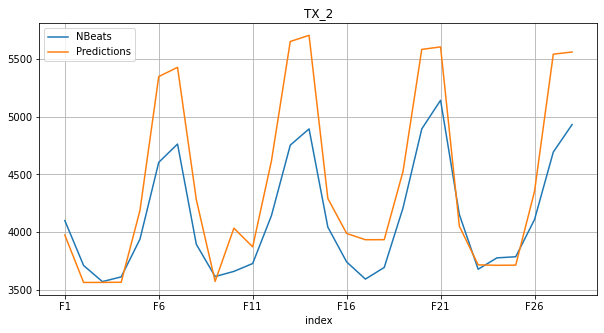

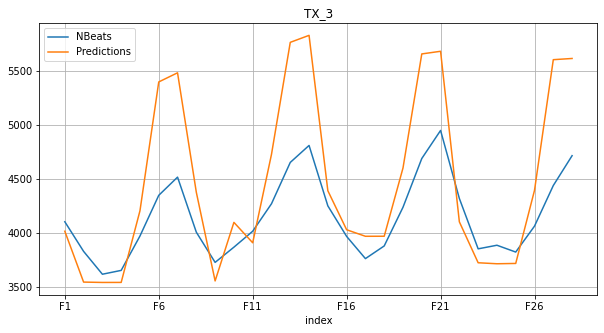

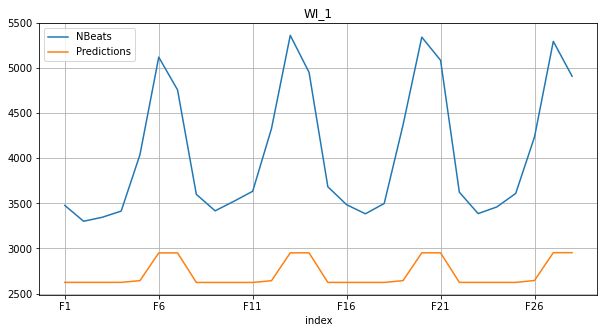

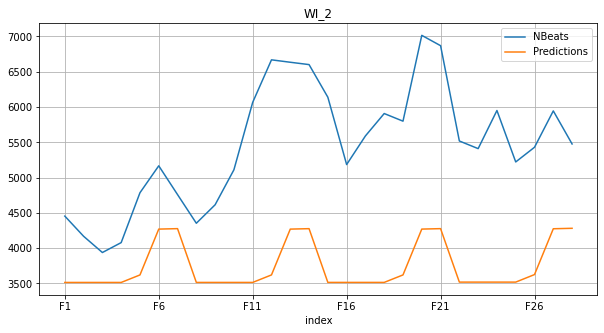

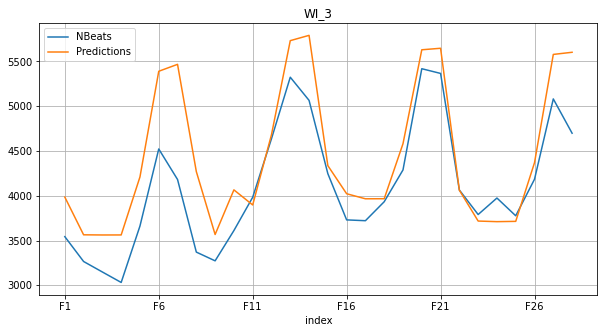

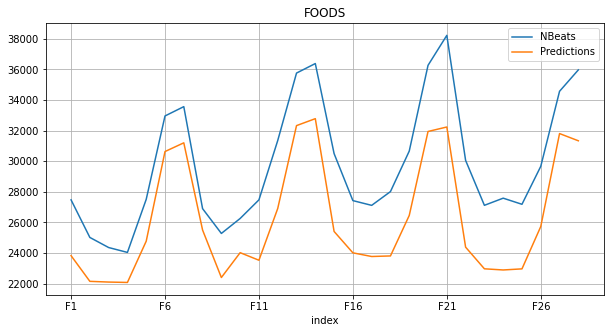

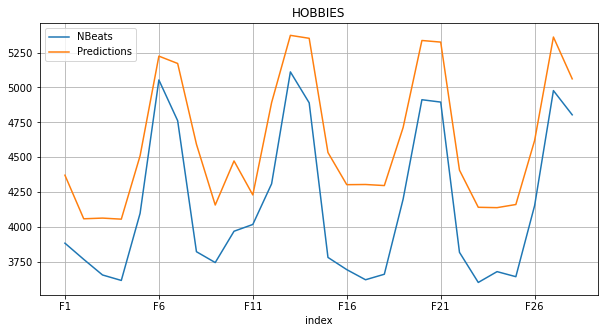

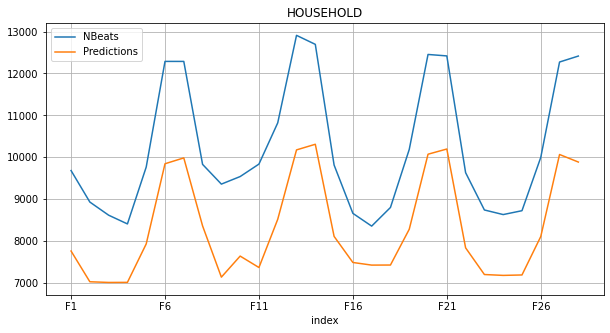

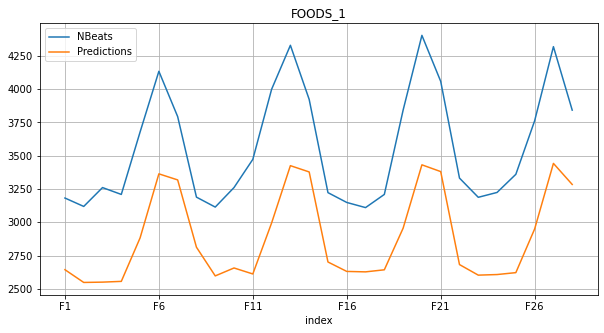

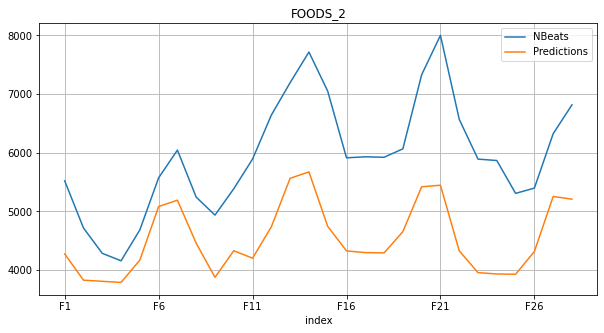

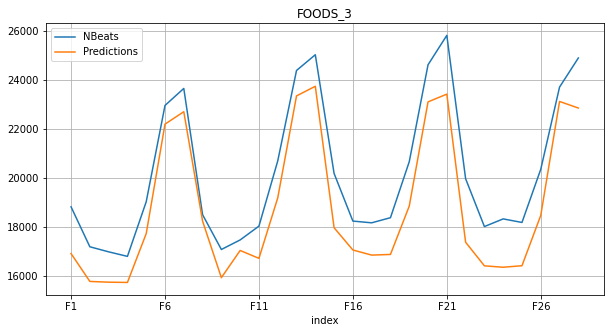

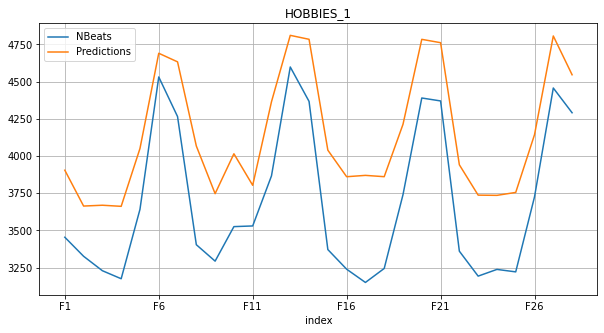

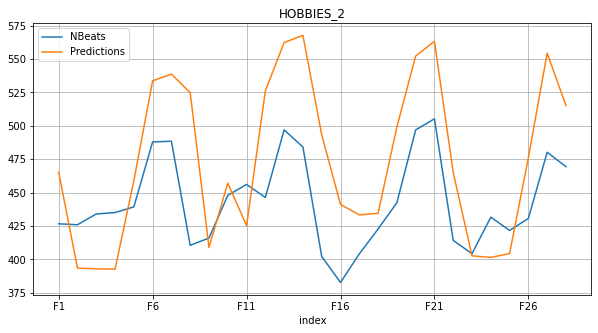

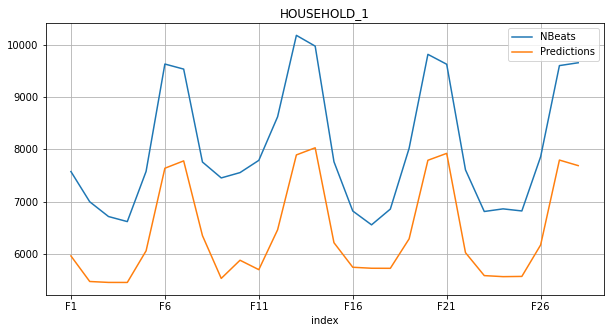

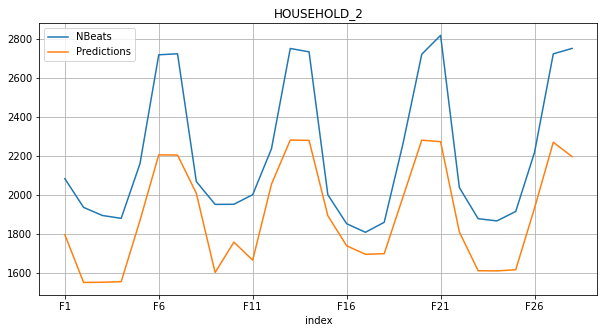

In [77]:
for i in range(0,nbeats_pred02_df.shape[0]):
    plot_df = pd.concat( [nbeats_pred02_df.iloc[i], all_pred_agg.iloc[i] ]  , axis=1, ignore_index=True)
    plot_df = plot_df.iloc[1:,]
    plot_df = plot_df.rename(columns={0:'NBeats',1:'Predictions'})
    plot_df = plot_df.reset_index()
    #plot_df
    
    plot_df.plot(x='index', y=['NBeats', 'Predictions'] ,figsize=(10,5), grid=True, title=nbeats_pred02_df.iloc[i,0]  )

# Submit based on above analysis and manual selection/clearance

In [24]:
submission_pred_df

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,1,0,0,0,0,0,1,0,4,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,1,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,3,1,2,1,3,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,1,0,4,4,0,1,4,0,1,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0.811978,0.678273,0.678273,0.678273,0.801154,1.142716,1.153842,0.908812,0.678273,...,0.911571,1.203752,1.198238,0.819799,0.710735,0.710735,0.710735,0.833616,1.179547,1.18656
60976,FOODS_3_824_WI_3_evaluation,0.756993,0.621691,0.621691,0.621691,0.753268,1.100218,1.111344,0.864087,0.621691,...,0.871798,1.164732,1.162307,0.765964,0.660719,0.660719,0.660719,0.792296,1.143615,1.153405
60977,FOODS_3_825_WI_3_evaluation,0.986588,0.847466,0.847466,0.847466,1.021646,1.370305,1.381431,1.068754,0.847466,...,1.152864,1.447507,1.441993,1.003512,0.894448,0.894448,0.894448,1.068627,1.421655,1.428668
60978,FOODS_3_826_WI_3_evaluation,1.333581,1.200802,1.200802,1.200802,1.421966,1.841961,1.842227,1.41796,1.200802,...,1.534255,1.904868,1.888494,1.349728,1.240663,1.240663,1.240663,1.461828,1.886191,1.876571


In [48]:
submission_pred_df.to_csv('results-100-1000.csv', index=False)
